In [1]:
import numpy as np
import scipy.spatial.distance as distance
import scipy.stats as stats
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist

In [3]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.initializers import RandomNormal, Zeros

In [4]:
class encoder_network():
    def __init__(self,sess,n_parts, input_dim, output_dim, n_hidden =400,dropout = False,rate = 0.3, mu = 0, sigma = 1):
        self.n_parts = n_parts
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.dropout = dropout
        self.rate = rate
        self.mu = mu
        self.sigma = sigma
        
        self.sess = sess
        
        self.phi = tf.placeholder(tf.float32,shape=(n_parts,self.output_dim))
        self.model = self.build_network()
        self.eta_grad = tf.gradients(tf.stop_gradient(self.phi)*self.model.output,self.model.trainable_weights)
    
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self):
        if self.dropout: 
            encoder_input = Input(batch_shape=(self.n_parts,self.input_dim))
            encoder_inputs = Dropout(self.rate)(encoder_input)
        else:
            encoder_inputs = Input(batch_shape=(self.n_parts,self.input_dim))
        encoder_hidden = Dense(self.n_hidden, activation='tanh',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = Zeros())(encoder_inputs)
        if self.dropout:
            encoder_hidden = Dropout(self.rate)(encoder_hidden)
        encoder_output = Dense(self.output_dim,
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = Zeros())(encoder_hidden)
        encoder = Model(inputs = encoder_inputs, outputs = encoder_output)
        
        return encoder
            
    def eval_eta_grad(self,x_in,phi):
        return self.sess.run(self.eta_grad, feed_dict={self.model.input : x_in,self.phi : phi})

In [5]:
class decoder_network():
    def __init__(self,sess,n_parts,input_dim,output_dim,n_hidden = 400,dropout = False,rate = 0.3, mu = 0, sigma = 1):
        self.n_parts = n_parts
        self.n_hidden = n_hidden
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.rate = rate
        self.mu = mu
        self.sigma = sigma
        
        self.sess = sess
        
        self.model = self.build_network()
        
        self.x_real = tf.placeholder(tf.float32, shape=(self.output_dim,))
        self.logpxz = self.build_logpxz(self.x_real, self.model.output)
        
        self.theta_grad = tf.gradients(self.logpxz, self.model.trainable_weights)
        self.z_grad = tf.gradients(self.logpxz, self.model.input)
        
        self.sess.run(tf.global_variables_initializer())
        
    def build_network(self):
        if self.dropout:
            decoder_input  = Input(batch_shape=(None, self.input_dim))
            decoder_inputs = Dropout(self.rate)(decoder_input)
        else:
            decoder_inputs = Input(batch_shape=(None, self.input_dim))
        decoder_hidden = Dense(self.n_hidden,activation='tanh',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = Zeros())(decoder_inputs)
        if self.dropout:
            decoder_hidden = Dropout(self.rate)(decoder_hidden)
        decoder_output = Dense(self.output_dim, activation='sigmoid',
                               kernel_initializer = RandomNormal(self.mu,self.sigma),
                               bias_initializer = Zeros())(decoder_hidden)
        decoder = Model(inputs = decoder_inputs, outputs = decoder_output)
        return decoder        
    
    # grad with respect to theta of log p(x|z)
    def eval_theta_grad(self,z,x_in):
        return self.sess.run(self.theta_grad,feed_dict={self.model.input:z, self.x_real:x_in})

    # grad with respect to z of log p(x|z)
    def eval_z_grad(self,z,x_in):
        return self.sess.run(self.z_grad,feed_dict={self.model.input:z, self.x_real:x_in})
    
    def eval_logpxz(self,z,x_in):
        return self.sess.run(self.logpxz,feed_dict={self.model.input:z, self.x_real:x_in})
    
    def build_logpxz(self, x_real, x_rec):
        x_real = tf.reshape(x_real,(1,self.output_dim))
        X_real = tf.tile(x_real,(self.n_parts,1))
        x_rec  = tf.reshape(x_rec,(self.n_parts,self.output_dim))
        
        fudge = 1e-15
        
        part1 = X_real * tf.log(tf.where(x_rec > fudge,x_rec,fudge * tf.ones_like(x_rec)))
        part2 = (1-X_real) * tf.log(tf.where(1-x_rec > fudge,1-x_rec,fudge * tf.ones_like(x_rec)))
        
        logpxz = tf.reduce_sum(part1+part2, axis=0)
        return logpxz

In [6]:
def rbf_kernel(x,h = -1):
        dist_mat = distance.squareform(distance.pdist(x)) **2 #use scipy package to calculate pairwise euclidean distance mat

        if h < 0 : #as suggested in the paper, calculate bandwith like so
            h = np.sqrt(0.5*np.median(dist_mat) / np.log(x.shape[0]+1))

        kxy = np.exp(-dist_mat / h**2 /2) #rbf kernel formula

        dkxy = -np.matmul(kxy , x) #first part of derivative of kxy
        for i in range(x.shape[1]): #second part of derivative of kxy
            dkxy[:,i] += x[:,i] * np.sum(kxy,axis=1)
        dkxy /= h**2

        return kxy, dkxy

In [7]:
def extend_input(x_input, loc, scale, n_parts,noise_dim = 1,shift_zeros = False):
    xsi = np.random.normal(loc,scale,size=(n_parts,noise_dim))
    x_extended = np.tile(x_input,(n_parts,1))
    if shift_zeros:
        x_extended[x_extended == 0] = -1
    assert np.shape(x_extended) == (n_parts, np.size(x_input))
    return np.hstack((x_extended,xsi))


In [8]:
def corrupt_input(x_input,n_parts,drop_rate, shift_zeros = True):
    x_input = np.tile(x_input,(n_parts,1))
    x_corrupt = x_input * np.random.binomial(n = 1 , p = drop_rate,size = x_input.shape)
    if shift_zeros:
        x_corrupt[x_corrupt == 0] = -1
    return x_corrupt

In [9]:
def dynamical_binarization(data):
    return np.random.binomial(n = 1, p = data)

In [89]:
(x_train_f, y_train_f), (x_test, y_test) = mnist.load_data()

num_samples = x_train_f.shape[0]
num_val = 10000
num_train = num_samples - num_val

orig_dim = x_train_f.shape[1:] #useful for restoring original images
flat_dim = orig_dim[0] * orig_dim[1] #output dimension


shuffle_idx = np.random.permutation(num_samples)
x_val = dynamical_binarization(x_train_f[shuffle_idx[:num_val]].copy().reshape(-1,flat_dim) / 255)
y_val = y_train_f[shuffle_idx[:num_val]].copy()
x_train = dynamical_binarization(x_train_f[shuffle_idx[num_val:]].copy().reshape(-1,flat_dim) / 255)
y_train = y_train_f[shuffle_idx[num_val:]].copy()

# x_train = dynamical_binarization(x_train_f[y_train_f == 0].reshape(-1,flat_dim) / 255)
# x_val = dynamical_binarization(x_train_f[y_train_f == 1].reshape(-1,flat_dim) / 255)

In [101]:
batch_size = 1
iters = 1000
n_parts = 50
latent_dim = 32
n_hidden = 400

drop_rate = 0.3

noise_dim = 0
input_dim = flat_dim  + noise_dim #input dimension

loc = 0
scale = 1
epsilon = 1e-4

en_sig = 0.02
de_sig = 0.02

In [102]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

encoder = encoder_network(sess, n_parts, input_dim, latent_dim,sigma = en_sig)
decoder = decoder_network(sess, n_parts, latent_dim, flat_dim,sigma = de_sig)

In [103]:
for t in range(iters):
    #x_input = extend_input(x_train[t],loc, scale, n_parts,noise_dim,shift_zeros=True)
    x_input = corrupt_input(x_train[t],n_parts,drop_rate)

    z = encoder.model.predict(x_input,batch_size=n_parts)
    
    z_grad = decoder.eval_z_grad(z,x_train[t])
    z_grad = np.array(z_grad).reshape(n_parts,latent_dim)
    
    if n_parts != 1:
        kzy, dkzy = rbf_kernel(z)
        phi = (kzy @ (z_grad - z) + dkzy) / n_parts
    else:
        phi = z_grad - z
    
    eta_grad = encoder.eval_eta_grad(x_input,phi)
    
    eta_1 = []
    for i,eta in enumerate(encoder.model.get_weights()):
        eta_1.append(eta + epsilon * eta_grad[i])
    encoder.model.set_weights(eta_1)
    
    theta_grad = decoder.eval_theta_grad(z,x_train[t])
    theta_1 = []
    for i,theta in enumerate(decoder.model.get_weights()):
        theta_1.append(theta + ((epsilon*theta_grad[i]) / n_parts))
    decoder.model.set_weights(theta_1) 

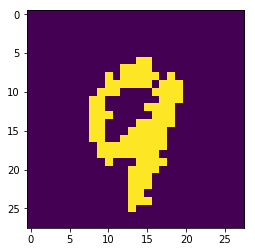

In [104]:
q =1
plt.imshow(x_val[q].reshape(orig_dim))

In [105]:
#test = extend_input(x_val[q],loc, scale, n_parts,noise_dim,shift_zeros=True)
test = corrupt_input(x_val[q],n_parts, drop_rate)
z = encoder.model.predict(test,batch_size=(n_parts))
x_rec = decoder.model.predict(z)

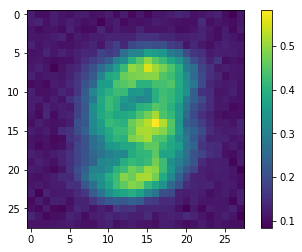

In [106]:
plt.imshow(x_rec[0].reshape(orig_dim))
plt.colorbar()
plt.show()

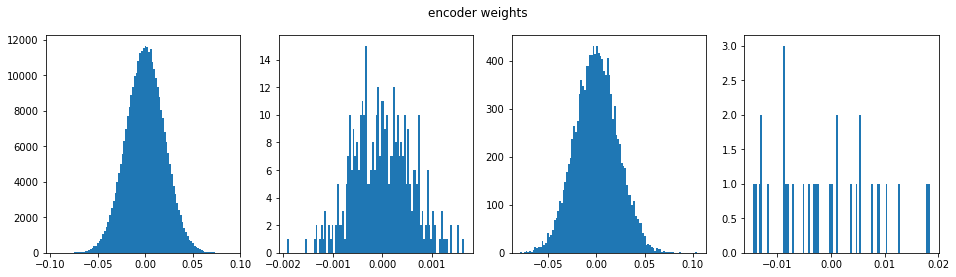

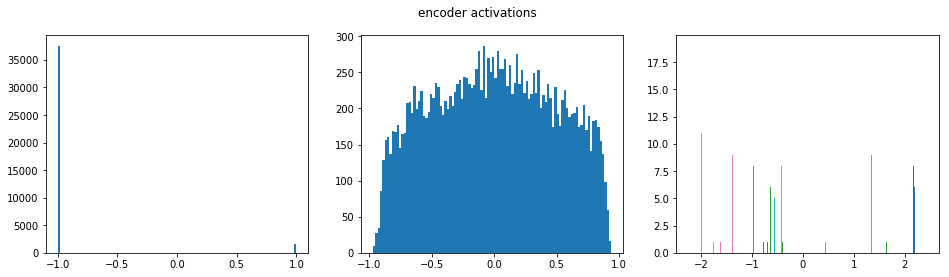

In [107]:
weights = encoder.model.get_weights()
fig,ax = plt.subplots(1,len(weights),figsize=(16,4))
fig.suptitle('encoder weights')
for i,weight in enumerate(weights):
    ax[i].hist(weight.reshape(-1),bins=100)
    
fig,ax = plt.subplots(1,len(encoder.model.layers),figsize=(16,4))
fig.suptitle('encoder activations')
for i,layer in enumerate(encoder.model.layers):
    activation = sess.run(layer.output,feed_dict={encoder.model.input:test})
    if i < len(encoder.model.layers)-1:
        ax[i].hist(activation.reshape(-1),bins=100)
    else :
        ax[i].hist(activation,bins=100)

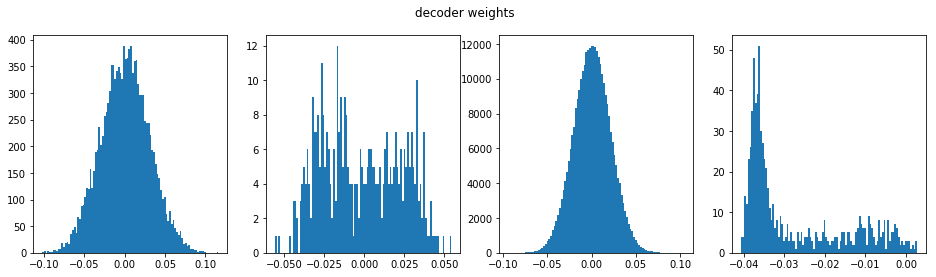

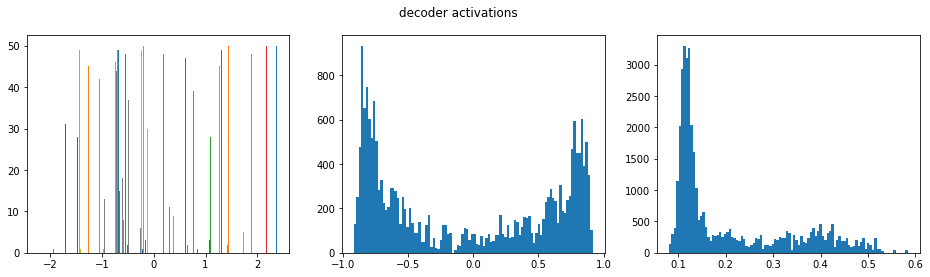

In [108]:
weights = decoder.model.get_weights()
fig,ax = plt.subplots(1,len(weights),figsize=(16,4))
fig.suptitle('decoder weights')
for i,weight in enumerate(weights):
    ax[i].hist(weight.reshape(-1),bins=100)
    
fig,ax = plt.subplots(1,len(decoder.model.layers),figsize=(16,4))
fig.suptitle('decoder activations')
for i,layer in enumerate(decoder.model.layers):
    activation = sess.run(layer.output,feed_dict={decoder.model.input:z})
    if i == 0:
        ax[i].hist(activation)
    else:
        ax[i].hist(activation.reshape(-1),bins=100)

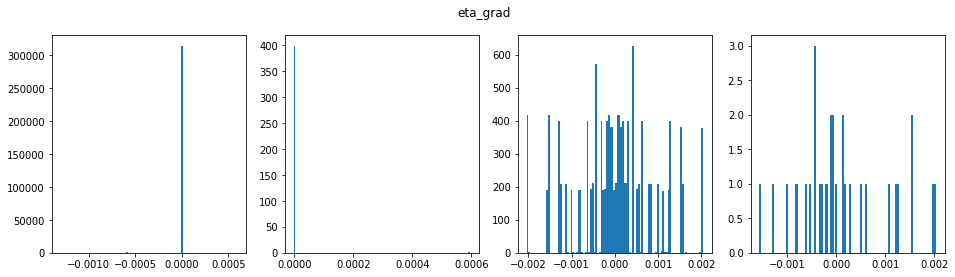

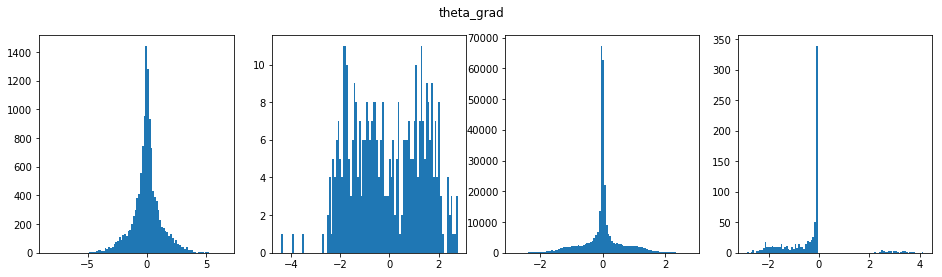

In [86]:
test_eta_grad =  encoder.eval_eta_grad(test,phi)
fig,ax = plt.subplots(1,len(test_eta_grad),figsize=(16,4))
fig.suptitle('eta_grad')
for i,g in enumerate([epsilon*eta.reshape(-1) for eta in test_eta_grad]):
    ax[i].hist(g,bins=100)
    
test_theta_grad = decoder.eval_theta_grad(z,x_val[q])
fig,ax = plt.subplots(1,len(test_theta_grad),figsize=(16,4))
fig.suptitle('theta_grad')
for i,g in enumerate([theta.reshape(-1) for theta in test_theta_grad]):
    ax[i].hist(g,bins=100)

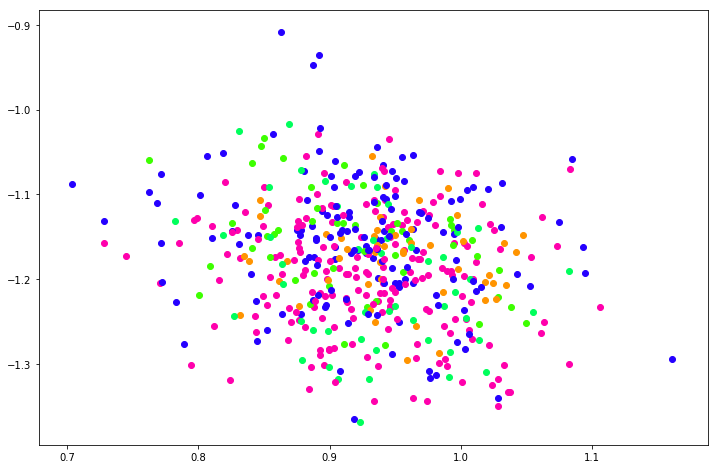

In [110]:
colors = plt.cm.hsv(np.arange(10)/10)
plt.figure(figsize=(12,8))
for q in range(10):
#    test_imgs = extend_input(x_val[q],loc,scale,n_parts = n_parts,noise_dim=noise_dim,shift_zeros=True)
    test_imgs = corrupt_input(x_val[q],n_parts, drop_rate)

    test_z = encoder.model.predict(test_imgs,batch_size=(n_parts))
    plt.scatter(test_z[:,0],test_z[:,1],c = colors[y_val[q]].reshape(1,4),)

In [ ]:
pure_eta = sess.run(tf.gradients(encoder.model.output,encoder.model.trainable_weights),
                    feed_dict={encoder.model.input:test})
plt.hist(pure_eta[0].reshape(-1),bins=100)
plt.show()

fig,ax = plt.subplots(1,len(pure_eta),figsize=(16,4))
fig.suptitle('eta_grad')
for i,g in enumerate([epsilon * eta.reshape(-1) for eta in pure_eta]):
    ax[i].hist(g,bins=100)

In [ ]:
test_grad_z = decoder.eval_z_grad(z,x_val[q])
test_grad_z = np.array(z_grad).reshape(n_parts,latent_dim)
fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].hist(test_grad_z[:,0],bins=100)
ax[1].hist(test_grad_z[:,1],bins=100)
plt.suptitle('z_grad')

In [ ]:
kzy, dkzy = rbf_kernel(z)
phi = (kzy @ (test_grad_z - z) + dkzy) / n_parts
plt.hist(phi,bins=100)
plt.title('phi')
plt.show()
np.ptp(dkzy)

In [ ]:
#     def build_grad(self):
#         grads = []
#         for eta in self.model.trainable_weights:
#             a = []
#             for i in range(self.n_parts):
#                 b = []
#                 for j in range(self.output_dim):
#                     b.append(tf.gradients(self.model.output[i,j],eta))
#                 a.append(b)
#             grads.append(a)
#         return grads

#     eta_1 = []
#     for i,eta in enumerate(encoder.model.get_weights()):
#         a = np.array(eta_grad[i]).reshape(n_parts,latent_dim,-1)
#         b = np.array([np.matmul(phi[j,:].reshape(1,latent_dim),a[j,:,:]) for j in range(n_parts)])
        
#         eta_1.append(eta + epsilon * np.sum(b,axis=0).reshape(eta.shape))
#     encoder.model.set_weights(eta_1)

In [ ]:
wat = x_val[q] * np.log(np.where(x_rec >= 1e-15,x_rec,np.ones(x_rec.shape)*1e-15)) 
+ (1-x_val[q]) * np.log(np.where(1 - x_rec >= 1e-15,1 - x_rec,1 - np.ones(x_rec.shape)*1e-15))
np.mean(np.sum(np.where(x_val[q] == 1,x_val[q] * np.log(np.where(x_rec >= 1e-15,x_rec,np.ones(x_rec.shape)*1e-15)),
       (1-x_val[q]) * np.log(np.where(1 - x_rec >= 1e-15,1 - x_rec,1 - np.ones(x_rec.shape)*1e-15))),axis=0))

x_real = tf.placeholder(shape = (1,flat_dim,),dtype=tf.float32)
X_real = tf.tile(x_real,(n_parts,1))
x_rec  = tf.reshape(x_rec,(n_parts,flat_dim))

fudge = 1e-15
part1 = X_real * tf.log(tf.where(x_rec > fudge,x_rec,fudge * tf.ones_like(x_rec)))
part2 = (1-X_real) * tf.log(tf.where(1-x_rec > fudge,1-x_rec,fudge * tf.ones_like(x_rec)))

logpxz = tf.reduce_sum(part1+part2, axis=0)
blubbers = sess.run(logpxz,feed_dict={x_real :x_val[q].reshape(1,flat_dim)})
np.mean(blubbers)

In [ ]:
wat1 = x_val[q] * np.log(np.where(x_rec >= 1e-15,x_rec,np.ones(x_rec.shape)*1e-15)) 
wat2 = (1-x_val[q]) * np.log(np.where(1 - x_rec >= 1e-15,1 - x_rec,1 - np.ones(x_rec.shape)*1e-15))
wat = wat1+wat2
wat = np.sum(wat,axis=0)
loss = 0
for q in range(num_val):    
    test = extend_input(x_val[q],loc, scale, n_parts,noise_dim,shift_zeros=True)
    z = encoder.model.predict(test,batch_size=(n_parts))
    test_logp=decoder.eval_logpxz(z,x_val[q])
    loss += np.mean(test_logp)